In [1]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm

THEANO_FLAGS = 'exception_verbosity=high'

# Test 1: Scalar ODE with 1 parameter

$$ y' = exp(-t) - \alpha y \quad y(0) = 0 $$

In [2]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 1
n_odeparams = 2

#Times to evaluate the solution
times = np.arange(0.25,8,0.25)

#Instantiate the ODEModel
ode_model = ODEModel(func = test_ode_func_2, 
                   t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_odeparams = n_odeparams)

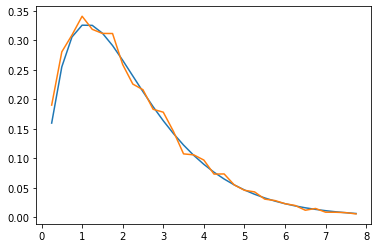

In [3]:
#Simulate the data and create data to learn from
sims, sens = ode_model.simulate([0.8,1,0])


Y = scipy.stats.lognorm.rvs(s = 0.1, scale = sims)


plt.plot(times, sims)
plt.plot(times,Y)




In [4]:
# class solveCached(object):
#     def __init__(self, times, n_params, n_outputs):
      
#         self._times = times
#         self._n_params = n_params
#         self._n_outputs = n_outputs
#         self._cachedParam = np.zeros(n_params)
#         self._cachedSens = np.zeros((len(times), n_outputs, n_params))
#         self._cachedState = np.zeros((len(times),n_outputs))
        
#     def __call__(self, x):
        
#         if np.all(x==self._cachedParam):
#             state, sens = self._cachedState, self._cachedSens
            
#         else:
#             state, sens = ode_model.simulate(x)
        
#         return state,sens
    

# cached_solver=solveCached(times, 1 + 1, 1)

In [5]:
# def state(x):
# #     State, Sens = cached_solver(np.array(x,dtype=np.float64))
#     State, Sens = ode_model.cached_simulate(np.array(x,dtype=np.float64))
#     ode_model.cached_y, ode_model.cached_sens, ode_model.cached_parameters = State, Sens, x
#     return State.ravel()

# def numpy_vsp(x, g):    
#     numpy_sens = ode_model.cached_simulate(np.array(x,dtype=np.float64))[1].reshape((n_states*len(times),len(x)))
#     return numpy_sens.T.dot(g)

# class ODEGradop(theano.Op):
#     def __init__(self, numpy_vsp):
#         self._numpy_vsp = numpy_vsp

#     def make_node(self, x, g):
#         x = theano.tensor.as_tensor_variable(x)
#         g = theano.tensor.as_tensor_variable(g)
#         node = theano.Apply(self, [x, g], [g.type()])
#         return node

#     def perform(self, node, inputs_storage, output_storage):
#         x = inputs_storage[0]

#         g = inputs_storage[1]
#         out = output_storage[0]
#         out[0] = self._numpy_vsp(x, g)       # get the numerical VSP

# class ODEop(theano.Op):

#     def __init__(self, ode_model):
#         self._state = ode_model.state
#         self._numpy_vsp = ode_model.numpy_vsp

#     def make_node(self, x):
#         x = theano.tensor.as_tensor_variable(x)

#         return theano.Apply(self, [x], [x.type()])

#     def perform(self, node, inputs_storage, output_storage):
#         x = inputs_storage[0]
#         out = output_storage[0]
        
#         out[0] = self._state(x)               # get the numerical solution of ODE states

#     def grad(self, inputs, output_grads):
#         x = inputs[0]
#         g = output_grads[0]

#         grad_op = ODEGradop(self._numpy_vsp)  # pass the VSP when asked for gradient 
#         grad_op_apply = grad_op(x, g)
        
#         return [grad_op_apply]
    
my_ODEop = ODEop(ode_model)


In [6]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    alpha = pm.HalfNormal('alpha',1)
    beta = pm.HalfNormal('beta',1)
    y0 = pm.HalfNormal('y0',1)
    sigma = pm.HalfCauchy('sigma',1)

    # Forward model
    all_params = pm.math.stack([alpha, beta, y0],axis=0)
    pprint = tt.printing.Print('all_params')(all_params)
    
    ode_sol = my_ODEop(all_params)
    oprint = tt.printing.Print('ode_sol')(ode_sol)
    
    forward = ode_sol.reshape(Y.shape)
    fprint = tt.printing.Print('forward')(pm.math.log(forward))
    
    ode = pm.Deterministic('ode',ode_sol)
    
    

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)
#     Y_obs = pm.Normal('Y_obs', mu=forward, sd=sigma, observed=Y)
#     Y_obs = pm.Lognormal('Y_obs', mu=forward, sd=sigma, observed=Y)
    
    trace = pm.sample(1000, tune=500, chains = 4, init='adapt_diag', target_accept = 0.99)



all_params __str__ = [0.79788456 0.79788456 0.79788456]
ode_sol __str__ = [0.81699774 0.80310603 0.76752135 0.71854371 0.66218068 0.60270498
 0.54308555 0.48531934 0.43068573 0.37994082 0.33346477 0.29137311
 0.25359997 0.21995992 0.1901934  0.16399953 0.14105962 0.12105336
 0.10366993 0.08861495 0.07561475 0.06441851 0.0547989  0.04655185
 0.0394955  0.03346892 0.02833041 0.02395587 0.02023703 0.01707979
 0.01440265]
forward __str__ = [[-0.20211895]
 [-0.21926853]
 [-0.26458899]
 [-0.33052873]
 [-0.41221684]
 [-0.50632746]
 [-0.61048842]
 [-0.72294818]
 [-0.84237661]
 [-0.96773978]
 [-1.09821805]
 [-1.23315067]
 [-1.37199719]
 [-1.51430992]
 [-1.65971384]
 [-1.80789169]
 [-1.95857267]
 [-2.1115238 ]
 [-2.26654318]
 [-2.42345471]
 [-2.58210386]
 [-2.74235429]
 [-2.9040851 ]
 [-3.06718861]
 [-3.23156844]
 [-3.39713803]
 [-3.56381936]
 [-3.7315418 ]
 [-3.90024129]
 [-4.06985947]
 [-4.24034307]]


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, y0, beta, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [07:09<00:00,  5.91draws/s]


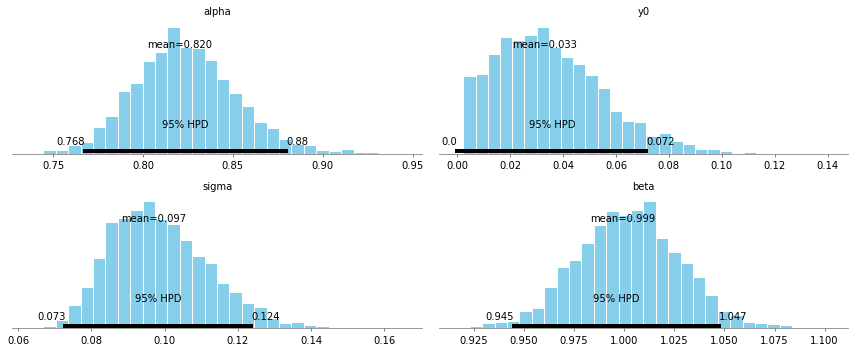

In [7]:
pm.posteriorplot.plot_posterior(trace,varnames = ['alpha','y0','sigma','beta']);

In [8]:
print(pm.gelman_rubin(trace))

print(pm.effective_n(trace))

{'alpha': 1.0022756650115867, 'beta': 1.0018320470788757, 'y0': 1.0018887103867735, 'sigma': 0.9998703898251012, 'ode': array([1.00128415, 1.00076226, 1.00071831, 1.00090972, 1.00108849,
       1.00120193, 1.00125769, 1.00126917, 1.00124605, 1.00119437,
       1.00111786, 1.00101916, 1.00090087, 1.00076658, 1.00062188,
       1.00047532, 1.00033888, 1.00022734, 1.00015602, 1.00013711,
       1.00017584, 1.00026856, 1.00040392, 1.0005665 , 1.00074094,
       1.00091472, 1.00107929, 1.00122977, 1.00136412, 1.00148213,
       1.00158471])}
{'alpha': 1269.1018081185598, 'beta': 1300.8212256619238, 'y0': 1463.5767674773522, 'sigma': 2001.3522642622067, 'ode': array([1979.07171875, 2655.54949969, 2569.7681596 , 2140.80324913,
       1861.35385461, 1702.32147886, 1611.95583848, 1567.96764964,
       1549.53159273, 1551.15465194, 1571.17386734, 1608.9551537 ,
       1664.35721357, 1745.89771332, 1860.63633314, 2017.89062212,
       2228.32464879, 2500.63037646, 2834.16464559, 3207.79207544,
  

In [9]:
with first_model:
    ppc = pm.sample_ppc(trace)

100%|██████████| 1000/1000 [00:17<00:00, 56.67it/s]


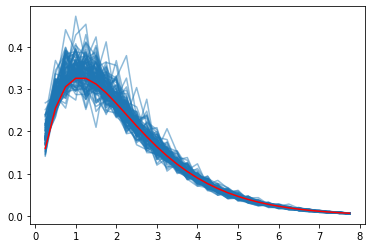

In [10]:
yobs = ppc['Y_obs']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.5)
    
plt.plot(times,sims, color = 'red')

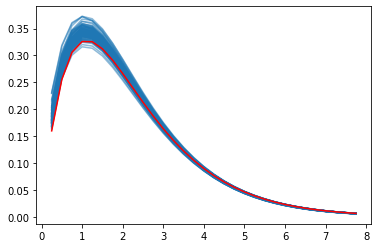

In [11]:
yobs = trace['ode']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.5)
    
plt.plot(times,sims, color = 'red')

In [12]:
?pm.posteriorplot.plot_posterior